# ARMAX Example

This notebook demonstrates the ARMAX model identification and validation process.

In [1]:
import numpy as np
from control import frequency_response
from control.timeresp import step_response
from sklearn.metrics import explained_variance_score, root_mean_squared_error
from sklearn.pipeline import Pipeline

from sippy_unipi.datasets import load_sample_siso
from sippy_unipi.io import ARMAX
from sippy_unipi.plot import (
    plot_bode,
    plot_response,
    plot_responses,
)
from sippy_unipi.preprocessing import StandardScaler

seed = 0
np.random.seed(seed)

# Enable automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

## Load Sample Data

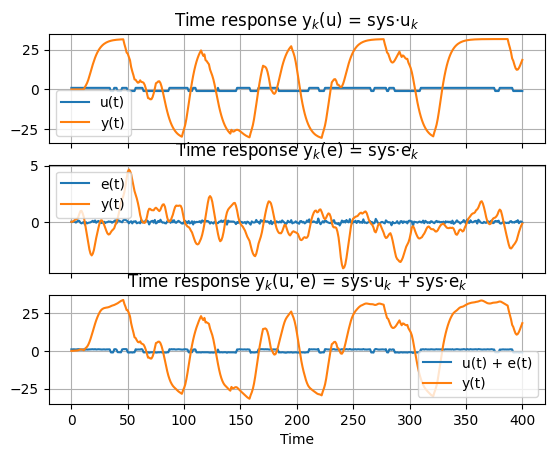

In [2]:
ylegends = ["System", "ARMAX-I", "ARMAX-0", "ARMAX-R"]
n_samples = 401
ts = 1
time, Ysim, Usim, g_sys, Yerr, Uerr, h_sys, Ytot, Utot = load_sample_siso(
    n_samples, ts, seed=0
)

fig = plot_responses(
    time,
    [Usim, Uerr, Utot],
    [Ysim, Yerr, Ytot],
    ["u", "e", ["u", "e"]],
)

## System Identification

In [3]:
na = 4
nb = 3
nc = 2
th = 11

models = [
    Pipeline(
        [
            ("scaler", StandardScaler()),
            ("model", ARMAX(na, nb, nc, th, ts, method="ills")),
        ]
    ),
    Pipeline(
        [
            ("scaler", StandardScaler()),
            ("model", ARMAX(na, nb, nc, th, ts, method="opt")),
        ]
    ),
    Pipeline(
        [
            ("scaler", StandardScaler()),
            ("model", ARMAX(na, nb, nc, th, ts, method="rlls")),
        ]
    ),
]

In [4]:
Ys_pred = []
for model in models:
    model.fit(Usim.reshape(-1, 1), Ytot.reshape(-1, 1))
    Ys_pred.append(model.predict(Usim.reshape(-1, 1)))

## Check Consistency of the Identified System

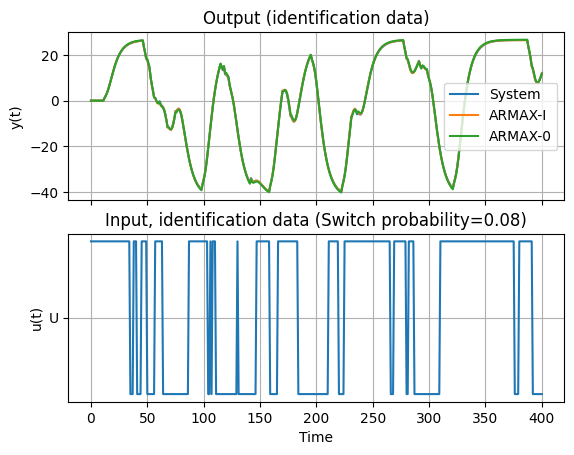

In [5]:
fig = plot_response(
    time,
    Ys_pred,
    Usim,
    legends=[ylegends, ["U"]],
    titles=[
        "Output (identification data)",
        "Input, identification data (Switch probability=0.08)",
    ],
)

## Validation of the Identified System

In [6]:
time, Ysimval, Usimval, g_sys, Yerrval, Uerrval, h_sys, Yval, Uval = (
    load_sample_siso(
        n_samples, ts, input_range=(0.5, 1.5), switch_probability=0.07, seed=0
    )
)

Ysv_pred = [Yval]
scores = {"rmse": [], "ev": []}
for model_fitted in models:
    Y_pred = model_fitted.predict(Uval)
    scores["rmse"].append(root_mean_squared_error(Yval, Y_pred))
    scores["ev"].append(explained_variance_score(Yval, Y_pred))
    Ysv_pred.append(Y_pred)

In [7]:
# Print scores in a formatted table
print("Model Performance Metrics:")
print("-" * 50)
print(f"{'Model':<20} {'RMSE':<10} {'Explained Variance':<20}")
print("-" * 50)

for i, model_name in enumerate(ylegends):
    if i == 0:  # Skip the first one which is the actual data
        continue
    rmse_value = scores["rmse"][i - 1]
    ev_value = scores["ev"][i - 1]
    print(f"{model_name:<20} {rmse_value:<10.4f} {ev_value:<20.4f}")
print("-" * 50)


Model Performance Metrics:
--------------------------------------------------
Model                RMSE       Explained Variance  
--------------------------------------------------
ARMAX-I              5.0047     0.9710              
ARMAX-0              5.0538     0.9710              
ARMAX-R              4.9248     0.9699              
--------------------------------------------------


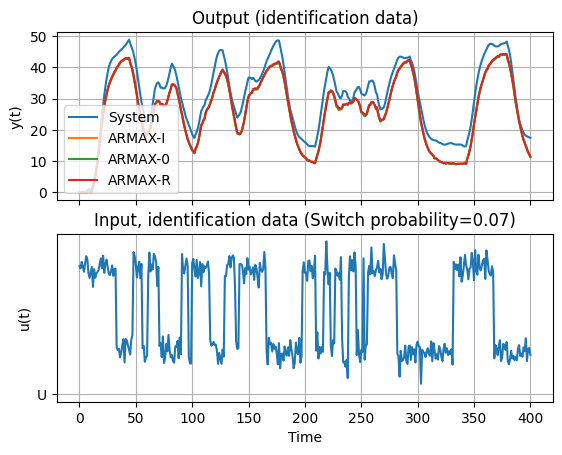

In [8]:
fig = plot_response(
    time,
    Ysv_pred,
    Uval,
    legends=[ylegends, ["U"]],
    titles=[
        "Output (identification data)",
        "Input, identification data (Switch probability=0.07)",
    ],
)

## Step Tests

/Users/mw/pyprojects/SIPPY/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")


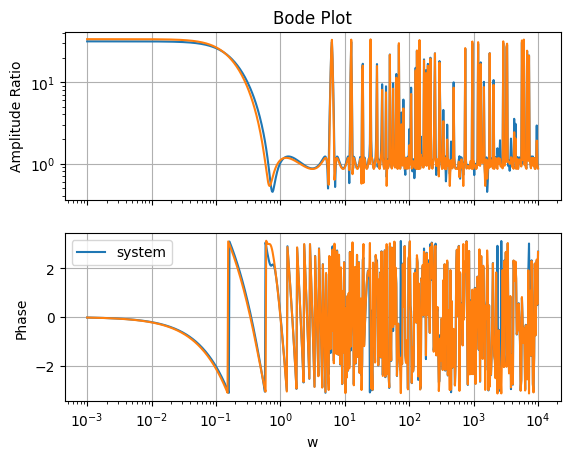

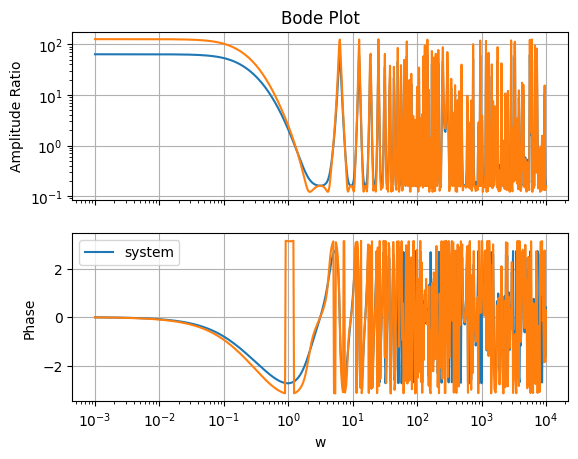

In [9]:
W_V = np.logspace(-3, 4, num=701)
for tf in ["G_", "H_"]:
    syss_tfs = [
        locals()[f"{tf.lower()}sys"],
        getattr(model_fitted.steps[-1][1], tf),
    ]
    mags, fis, oms = zip(*[frequency_response(sys, W_V) for sys in syss_tfs])

    fig = plot_bode(
        oms[0],
        mags,
        fis,
        ["system"],
    )

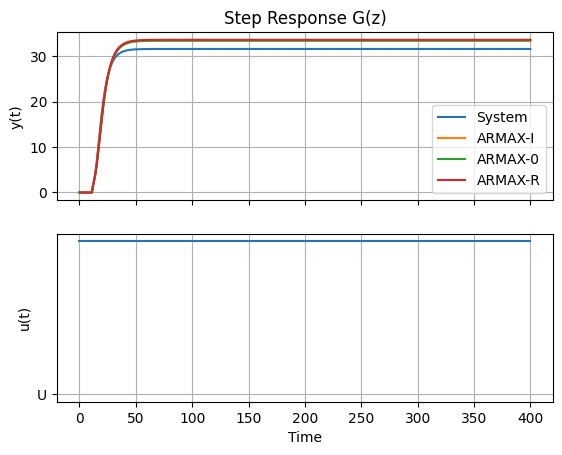

In [10]:
systems = [g_sys] + [model.steps[-1][1].G_ for model in models]
_, ys = zip(*[step_response(sys, time) for sys in systems])

fig = plot_response(
    time,
    ys,
    np.ones_like(time),
    legends=[ylegends, ["U"]],
    titles=["Step Response G(z)", None],
)

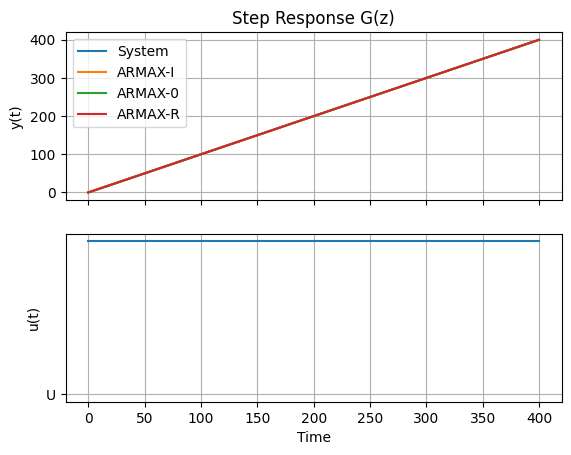

In [11]:
systems = [h_sys] + [model.steps[-1][1].H_ for model in models]
ys, _ = zip(*[step_response(sys, time) for sys in systems])

fig = plot_response(
    time,
    ys,
    np.ones_like(time),
    legends=[ylegends, ["U"]],
    titles=["Step Response G(z)", None],
)